# Problem Set #5
# MACS 30150, Dr. Evans
## Submitted by- Nipun Thakurele

## Problem 1

In [130]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
import pandas as pd
%matplotlib notebook

import requests
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [131]:
# Save the data file incomes.txt

pts = np.loadtxt("/Users/nipunthakurele/Desktop/UChicago/winter_2019/persp/persp-model-econ_W19/ProblemSets/PS5/data/incomes.txt", delimiter="\n")
pts = np.array(pts)

In [132]:
# Define function that generates values of a normal pdf
def log_norm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log-normal pdf with mean mu and standard
    deviation sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the log-normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''    
    pdf_vals    = (1/(xvals * sigma * np.sqrt(2 * np.pi))) *\
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))    
    return pdf_vals

In [133]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), standard deviation(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of incomes data
    std_data  = scalar > 0, standard deviation of incomes data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, std_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [134]:
def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    std_model  = scalar > 0, standard deviation of test scores from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * log_norm_pdf(x, mu, sigma)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, 150000)
    x2fx = lambda x: ((x - mean_model) ** 2) * log_norm_pdf(x, mu, sigma)
    (var_model, v_m_err) = intgr.quad(x2fx, 0, 150000)
    std_model = np.sqrt(var_model)
    return mean_model, std_model

In [135]:
def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    std_data   = scalar > 0, standard deviation of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [136]:
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the random variable
    sigma  = scalar > 0, standard deviation of the random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        lognorm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)     
    return crit_val

## Problem 1(a)

<IPython.core.display.Javascript object>


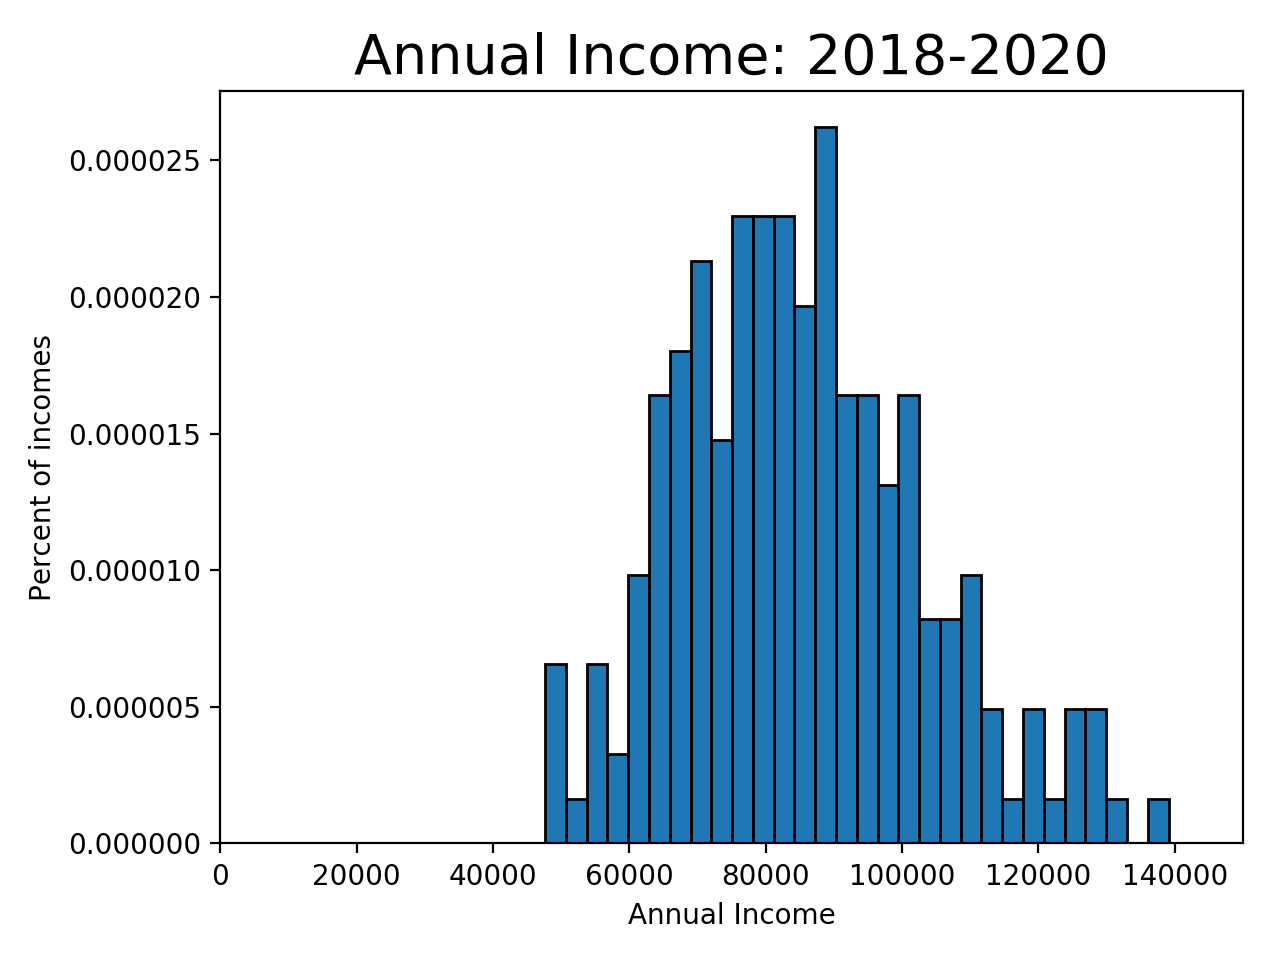

In [139]:
import matplotlib.pyplot as plt
%matplotlib notebook

num_bins = 30
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Annual Income: 2018-2020', fontsize=20)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent of incomes')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"
plt.tight_layout()

## Problem 1(b)

In [140]:
mu_init = 11.3
std_init = 0.21
params_init = np.array([mu_init, std_init])
W_hat = np.eye(2)
gmm_args = (pts, W_hat)

results = opt.minimize(criterion, params_init, args=(gmm_args), \
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, std_GMM1 = results.x
params_GMM = np.array([mu_GMM1, std_GMM1])
value = criterion(params_GMM, *gmm_args)
mu_data, std_data = data_moments(pts)
mu_model, std_model = model_moments(mu_GMM1, std_GMM1)

criterion_val = criterion(params_GMM,*gmm_args)
print("The value of criterion function at estimates is ",criterion_val[0][0])



The value of criterion function at estimates is  4.654809573766215e-12


In [141]:
#Report and compare your two data moments against your two model moments at the estimated parameter values.
mu_data, std_data = data_moments(pts)
mu_model, std_model = model_moments(mu_GMM1, std_GMM1)
err1 = err_vec(pts, mu_GMM1, std_GMM1, False).reshape(2,)
print('Estimates: mu = ', mu_GMM1, 'sigma = ', std_GMM1)
print('Mean of Incomes =', mu_data, ', Standard Deviation of Incomes =', std_data)
print('Mean of Model =', mu_model, ', Standard Deviation of Model =', std_model)

Estimates: mu =  11.336912595973413 sigma =  0.21302655486447097
Mean of Incomes = 85276.82360625811 , Standard Deviation of Incomes = 17992.542128046523
Mean of Model = 85277.0011879925 , Standard Deviation of Model = 17992.531976083257


<IPython.core.display.Javascript object>


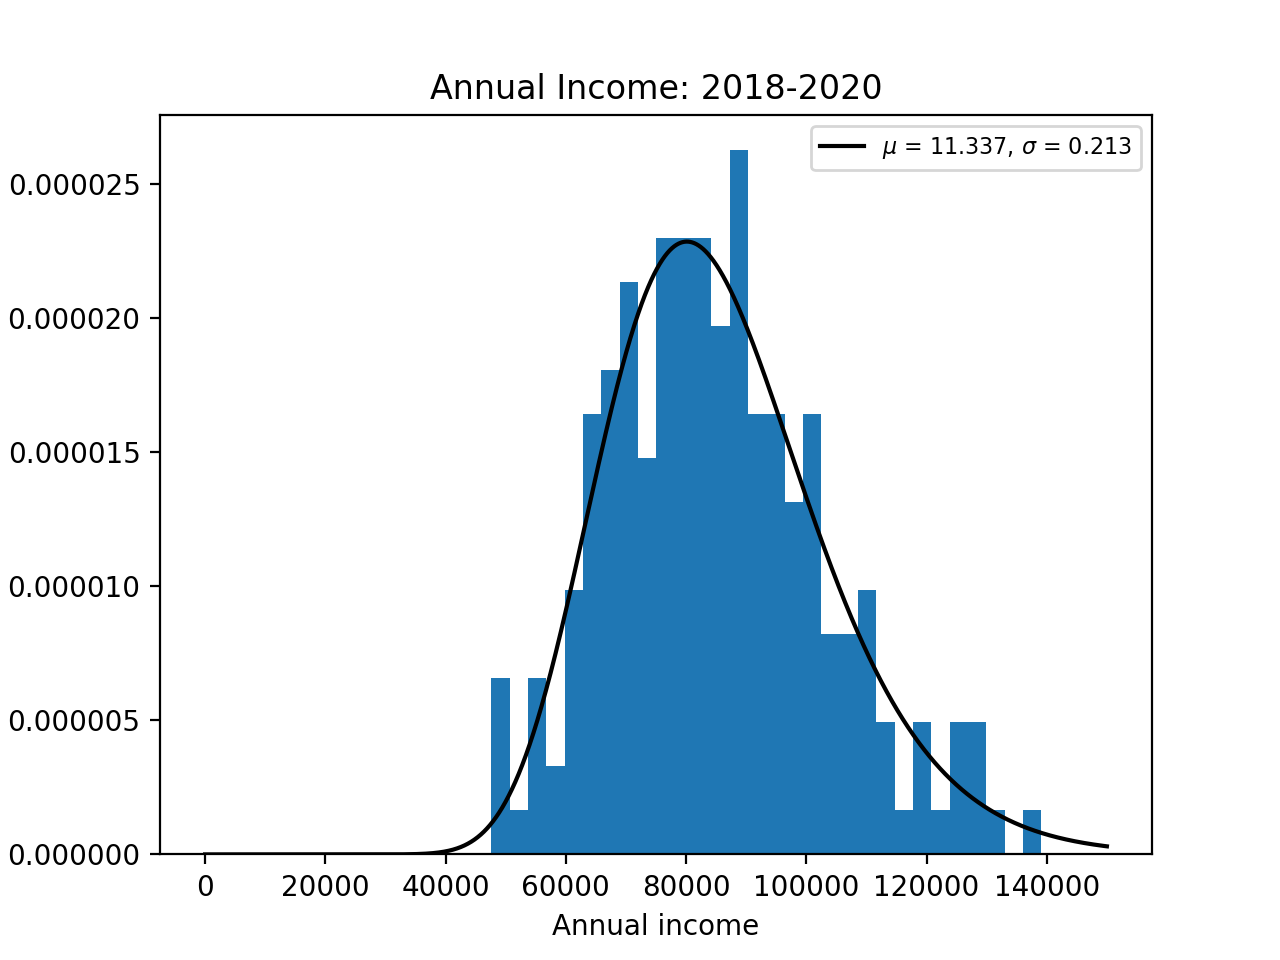

In [142]:
count, bins, ignored = plt.hist(pts, 30, normed = True)
plt.title('Annual Income: 2018-2020', fontsize = 12)
plt.xlabel(r'Annual income')
plt.ylabel(r'PDF Values')
dist_pts = np.linspace(0, 150000, 10000)
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM1, std_GMM1),
color='black', label=
'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(mu_GMM1, std_GMM1))
plt.legend(loc='upper right', prop={'size':8})

## Problem 1(c)

In [143]:
err1 = err_vec(pts, mu_GMM1, std_GMM1, False)
VCV = np.dot(err1, err1.T) / pts.shape[0]
W_hat2 = lin.pinv(VCV)

params_init = np.array([mu_GMM1, std_GMM1])
gmm2_args = (pts, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm2_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, std_GMM2 = results.x
params_GMM2 = np.array([mu_GMM2, std_GMM2])
criterion_val = criterion(params_GMM2,*gmm_args)
mu_data, std_data = data_moments(pts)
mu_model2, std_model2 = model_moments(mu_GMM2, std_GMM2)

print('mu_GMM2=', mu_GMM2, 'sig_GMM2=', std_GMM2)
print('The value of GMM criterion function at the estimated parameter values is:',criterion_val[0][0])
print('Estimates: \n mu = ', mu_GMM2, 'sigma = ', std_GMM2)
print("The value of the criterion function is ",criterion_val[0][0])

print('Mean of Incomes =', mu_data, ', Standard Deviation of Incomes =', std_data)
print('Mean of Model =', mu_model, ', Standard Deviation of Model =', std_model)
    

mu_GMM2= 11.336912458826959 sig_GMM2= 0.2130284165117713
The value of GMM criterion function at the estimated parameter values is: 5.377420579514635e-11
Estimates: 
 mu =  11.336912458826959 sigma =  0.2130284165117713
The value of the criterion function is  5.377420579514635e-11
Mean of Incomes = 85276.82360625811 , Standard Deviation of Incomes = 17992.542128046523
Mean of Model = 85277.0011879925 , Standard Deviation of Model = 17992.531976083257


In [144]:
print(results)

      fun: array([[7.49948259e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([211694.59337327, 526741.75757103])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 261
      nit: 4
   status: 2
  success: False
        x: array([11.33691246,  0.21302842])


<IPython.core.display.Javascript object>


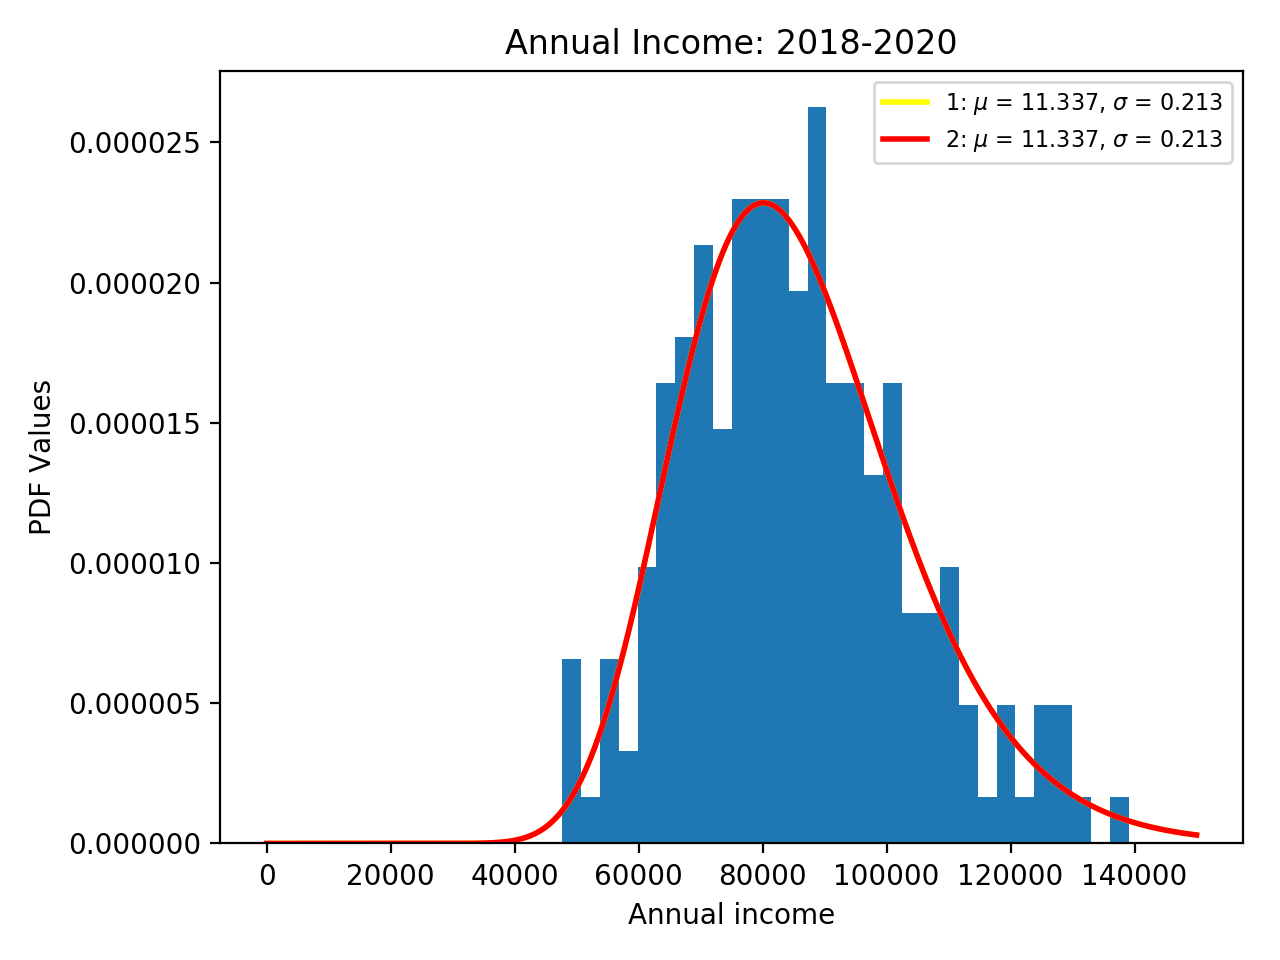

In [145]:
count, bins, ignored = plt.hist(pts, 30, normed = True)
plt.title('Annual Income: 2018-2020', fontsize = 12)
plt.xlabel(r'Annual income')
plt.ylabel(r'PDF Values')

dist_pts = np.linspace(0, 150000, 10000)
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM1, std_GMM1),
linewidth=2, color='yellow', label=
'1: $\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(mu_GMM1, std_GMM1))
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM2, std_GMM2),
linewidth=2, color='red', label=
'2: $\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(mu_GMM2, std_GMM2))
plt.legend(loc='upper right', prop={'size':8})
plt.tight_layout()

## Problem 1(d)

In [146]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, income data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 100000 <= x    

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[xvals >=100000].shape[0] /
                  xvals.shape[0])
    return (bpct_1_dat, bpct_2_dat, bpct_3_dat)




In [147]:
def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (bpct_1, bpct_2, bpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the random variable
    sigma  = scalar > 0, standard deviation of the random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: log_norm_pdf(x, mu, sigma)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 1500000)    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod






In [148]:
def err_vec3(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, income data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments3()
        model_moments3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    std_data   = scalar > 0, stdof data
    moms_data  = (2, 1) matrix, column vector of two data oments
    mean_model = scalar, mean value from model
    std_model  = scalar > 0, std from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    return err_vec



In [149]:
def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the random variable
    sigma  = scalar > 0, standard deviation of the random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [150]:
params_init = np.array([mu_init, std_init])
W_hat = np.eye(3)
gmm_args = (pts, W_hat)
results = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM3, std_GMM3 = results.x
params_GMM = np.array([mu_GMM3, std_GMM3])
criterion_value = criterion3(params_GMM, *gmm_args)
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM3, std_GMM3)

print('mu_GMM3 is', mu_GMM3, 'std_GMM3 is', std_GMM3, "\n")
print('The value of GMM criterion function at the estimated parameter values is:', criterion_value[0][0], "\n")
print('Data moments are:', "\n", 'Proportion of incomes that are less than $75000 = ', bpct_1_dat, "\n", \
      'Proportion of incomes that lie between $75000 and $100000 = ', bpct_2_dat, "\n", \
      'Proportion of incomes that are greater than $100000 = ', bpct_3_dat, "\n")
print('Model moments are:', "\n", 'Proportion of incomes that are less than $75000 = ', bpct_1_mod, "\n", \
      'Proportion of incomes that lie between $75000 and $100000 = ', bpct_2_mod, "\n", \
      'Proportion of incomes that are greater than $100000 = ', bpct_3_mod)

mu_GMM3 is 11.335681327894322 std_GMM3 is 0.2105984536659271 

The value of GMM criterion function at the estimated parameter values is: 2.2282390306263117e-11 

Data moments are: 
 Proportion of incomes that are less than $75000 =  0.3 
 Proportion of incomes that lie between $75000 and $100000 =  0.5 
 Proportion of incomes that are greater than $100000 =  0.2 

Model moments are: 
 Proportion of incomes that are less than $75000 =  0.3000000028100537 
 Proportion of incomes that lie between $75000 and $100000 =  0.5000000061140177 
 Proportion of incomes that are greater than $100000 =  0.19999999107592834


<IPython.core.display.Javascript object>


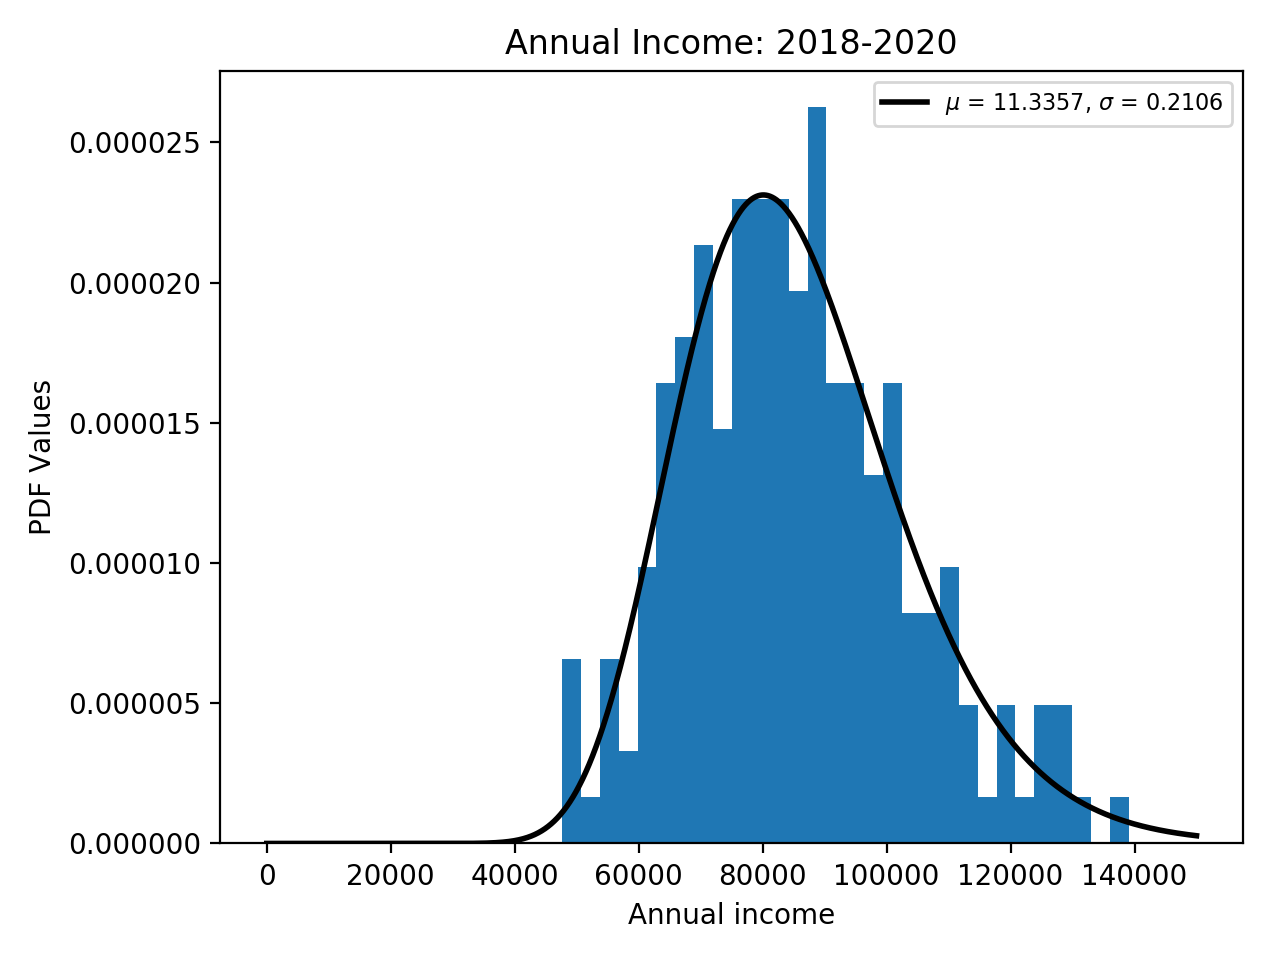

In [151]:
count, bins, ignored = plt.hist(pts, 30, normed = True)
plt.title('Annual Income: 2018-2020', fontsize = 12)
plt.xlabel(r'Annual income')
plt.ylabel(r'PDF Values')
dist_pts = np.linspace(0, 150000, 10000)
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM3, std_GMM3),
linewidth=2, color='black', label=
'$\mu$ = {:.4f}, $\sigma$ = {:.4f}'.format(mu_GMM3, std_GMM3))
plt.legend(loc='upper right', prop={'size':8})
plt.tight_layout()

## Problem 1(e)

In [152]:
err3 = err_vec3(pts, mu_GMM3, std_GMM3, False)
VCV2 = np.dot(err3, err3.T) / pts.shape[0]
W_hat2 = lin.pinv(VCV2)
params_init = np.array([mu_init, std_init])
gmm_args = (pts, W_hat2)
results = opt.minimize(criterion3, params_init, args=(gmm_args),
                method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM4, std_GMM4 = results.x
params_GMM = np.array([mu_GMM4, std_GMM4])
criterion_value = criterion3(params_GMM, *gmm_args)
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
bpct_1_mod2, bpct_2_mod2, bpct_3_mod2 = model_moments3(mu_GMM4, std_GMM4)

print('mu_GMM4 is', mu_GMM4, 'std_GMM4 is', std_GMM4, "\n")
print('The value of GMM criterion function at the estimated parameter values is:', criterion_value[0][0], "\n")
print('Data moments are:', "\n", 'Proportion of incomes that are less than $75000 = ', bpct_1_dat, "\n", \
      'Proportion of incomes that lie between $75000 and $100000 = ', bpct_2_dat, "\n", \
      'Proportion of incomes that are greater than $100000 = ', bpct_3_dat, "\n")
print('Model moments are:', "\n", 'Proportion of incomes that are less than $75000 = ', bpct_1_mod2, "\n", \
      'Proportion of incomes that lie between $75000 and $100000 = ', bpct_2_mod2, "\n", \
      'Proportion of incomes that are greater than $100000 = ', bpct_3_mod2)
   


mu_GMM4 is 11.320538543953525 std_GMM4 is 0.2296300575596015 

The value of GMM criterion function at the estimated parameter values is: 0.3985806191340089 

Data moments are: 
 Proportion of incomes that are less than $75000 =  0.3 
 Proportion of incomes that lie between $75000 and $100000 =  0.5 
 Proportion of incomes that are greater than $100000 =  0.2 

Model moments are: 
 Proportion of incomes that are less than $75000 =  0.3390730595279973 
 Proportion of incomes that lie between $75000 and $100000 =  0.459858917678084 
 Proportion of incomes that are greater than $100000 =  0.20106802279391828


<IPython.core.display.Javascript object>


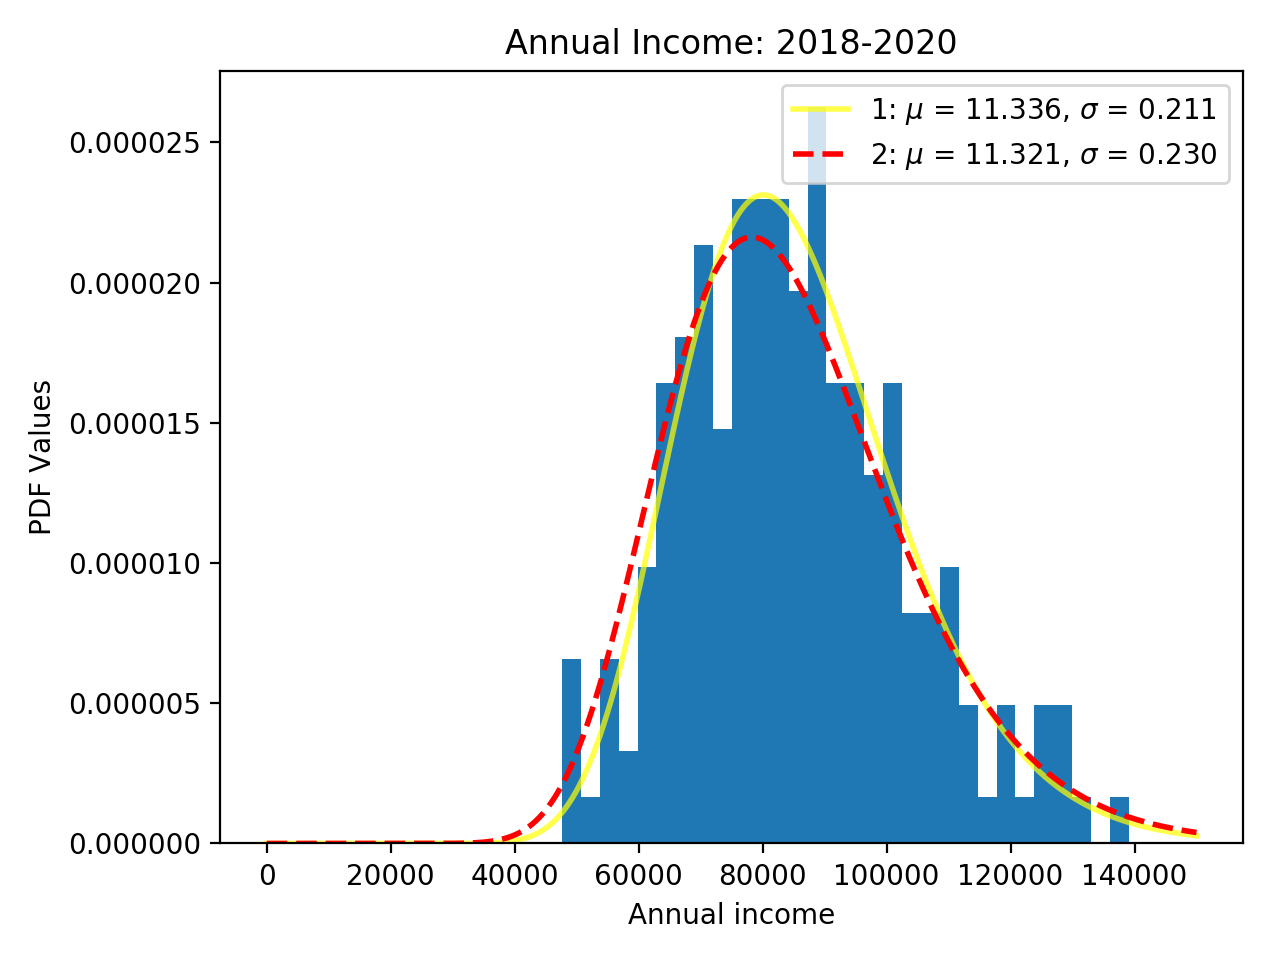

In [153]:
count, bins, ignored = plt.hist(pts, 30, normed = True)
plt.title('Annual Income: 2018-2020', fontsize = 12)
plt.xlabel(r'Annual income')
plt.ylabel(r'PDF Values')
dist_pts = np.linspace(0, 150000, 10000)
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM3, std_GMM3),
     linewidth=2, color='yellow', label=
     '1: $\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(mu_GMM3, std_GMM3),
      alpha = 0.7)
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM4, std_GMM4),
                   linewidth=2, color='red', label=
    '2: $\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(mu_GMM4, std_GMM4),
    linestyle = '--')
plt.legend(loc='upper right')
plt.tight_layout()

## Problem 1(f)

<IPython.core.display.Javascript object>


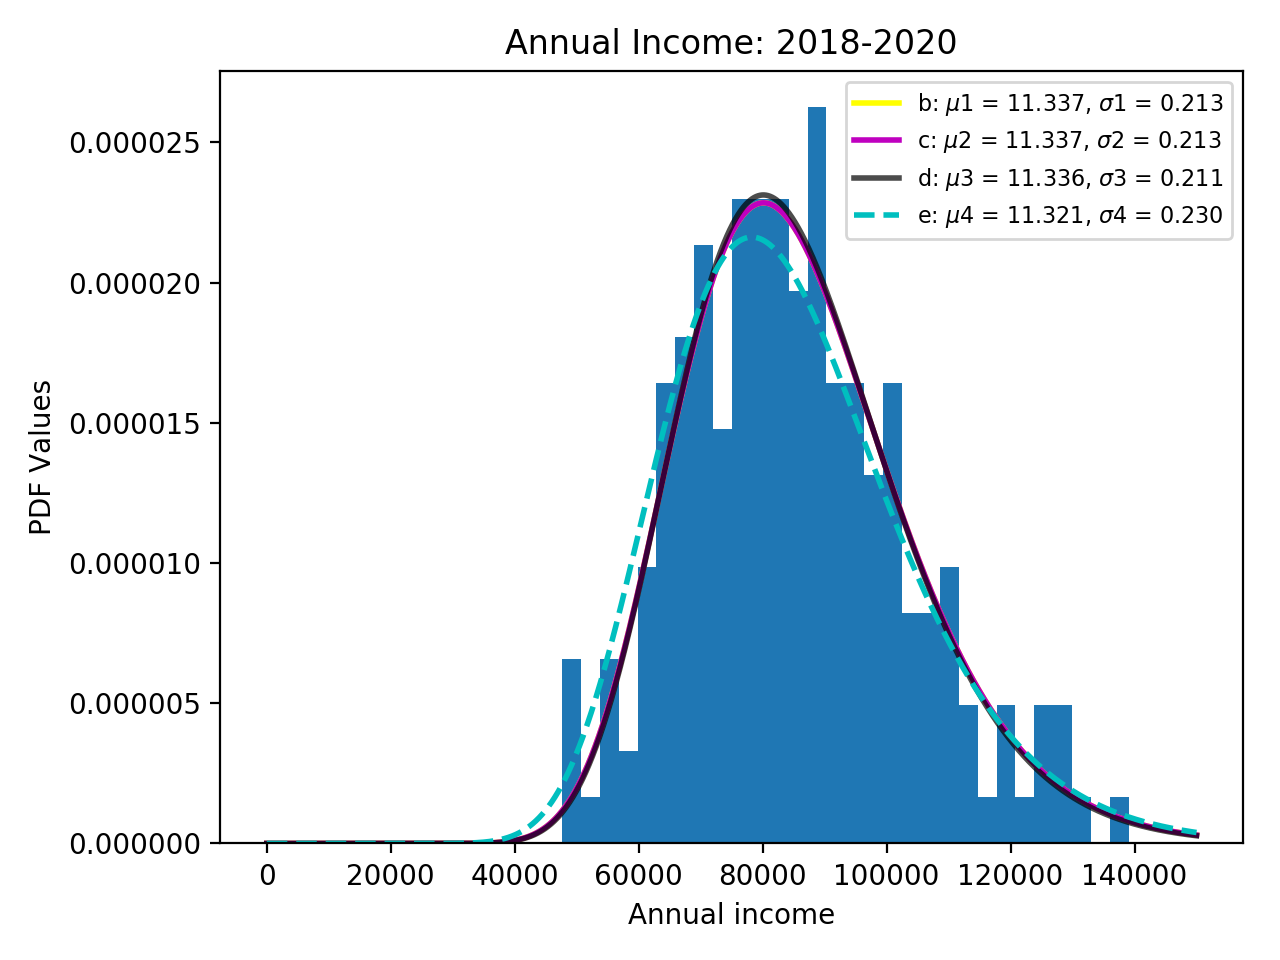

In [154]:
count, bins, ignored = plt.hist(pts, 30, normed = True)
plt.title('Annual Income: 2018-2020', fontsize = 12)
plt.xlabel(r'Annual income')
plt.ylabel(r'PDF Values')
dist_pts = np.linspace(0, 150000, 10000)
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM1, std_GMM1),
linewidth=2, color='yellow', label=
'b: $\mu1$ = {:.3f}, $\sigma1$ = {:.3f}'.format(mu_GMM1, std_GMM1))
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM2, std_GMM2),
linewidth=2, color='m', label=
'c: $\mu2$ = {:.3f}, $\sigma2$ = {:.3f}'.format(mu_GMM2, std_GMM2))
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM3, std_GMM3),
     linewidth=2, color='black', label=
     'd: $\mu3$ = {:.3f}, $\sigma3$ = {:.3f}'.format(mu_GMM3, std_GMM3),
      alpha = 0.7)
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM4, std_GMM4),
                   linewidth=2, color='c', label=
    'e: $\mu4$ = {:.3f}, $\sigma4$ = {:.3f}'.format(mu_GMM4, std_GMM4),
    linestyle = '--')
plt.legend(loc='upper right', prop={'size':8})
plt.tight_layout()

As seen in the figure above, the estimates corresponding to yellow and magenta colors (model b and model c, respectively) are the same and fits the data better than the model estimates represented by color cyan (model e).
Out of model b and model d (black color), the estimates of model d explains the variation in the data best. It not only has comparable mu value but also lesser sigma value than model b. Hence, model in part (d) fits the data best.

## Question 2

In [155]:
# Save the data from sick.txt
filename = "/Users/nipunthakurele/Desktop/UChicago/winter_2019/persp/persp-model-econ_W19/ProblemSets/PS5/data/sick.txt"
df = pd.read_csv(filename, skiprows = 1, names = ['sick', 'age', 'children', 'avgtemp_winter'])

In [156]:
def err_vec(xvals, params, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, sick data
    params = beta0, beta1, beta2, beta3
    
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
        
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    beta0, beta1, beta2, beta3 = params
    moms_data = np.array(xvals['sick'])
    moms_model = beta0 + beta1 * xvals['age'] + beta2 * xvals['children'] + beta3 * xvals['avgtemp_winter']

    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data

    return err_vec

In [157]:
def crit(params, xvals, W):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (4,) vector, ([beta0, beta1, beta2, beta3])
    xvals  = (N,) vector, values of the random variable
    W  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    err = err_vec(xvals, params, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val


In [159]:
params_init = np.array([0,0,0,0])
W_hat = np.eye(200)
gmm_args = (df, W_hat)
results = opt.minimize(crit, params_init, args=gmm_args,
        method='L-BFGS-B')
beta0_GMM, beta1_GMM, beta2_GMM, beta3_GMM = results.x
params_GMM = np.array([beta0_GMM, beta1_GMM,beta2_GMM, beta3_GMM ])
crit_value = crit(params_GMM, *gmm_args)

print(" Beta0:", beta0_GMM, "\n", "Beta1:", beta1_GMM, "\n", "Beta2:", beta2_GMM, "\n", "Beta3:", beta3_GMM, "\n")
print("The value of GMM criterion function at the estimated parameter values is:", crit_value)


 Beta0: 0.25220018350157025 
 Beta1: 0.013022300595994598 
 Beta2: 0.399781736997175 
 Beta3: -0.01005949360645394 

The value of GMM criterion function at the estimated parameter values is: 0.014856824347031315
